# Compare 3D cyl TDEM response of a horizontal electric dipole with analytic

In [1]:
# core python
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ipywidgets

# SimPEG
import discretize
from discretize import utils
from pymatsolver import Pardiso
from geoana.em import tdem

# casing utils
import casingSimulations

%matplotlib inline

In [2]:
simDir = 'compare_TDEM_hed'

In [3]:
# model parameters
sigma_back = 1e-1

src_a = np.r_[500-5, np.pi, 1.] # put the dipole at the surface, 500m from the "well"
src_b = np.r_[500+5, np.pi, 1.]

In [4]:
model = casingSimulations.model.Wholespace(
    directory=simDir,
    sigma_back=sigma_back,
    src_a=src_a,
    src_b=src_b,
)

In [5]:
model.timeSteps = [(1e-6, 10), (1e-5, 20), (1e-4, 20), (1e-3, 20), (1e-2, 20)] 

In [6]:
model.diffusion_distance()

1880.5802270695624

In [7]:
npadx, npadz = 10, 10
dx2 = 1000. 
csx = 20.
csz = 20.

ncy = 1
nstretchy = 5
stretchfact = 1.5
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

cylMeshGen = casingSimulations.CylMeshGenerator(
    directory=simDir,
    modelParameters=model, 
    npadx=npadx, 
    npadz=npadz, 
    domain_x=dx2, 
    hy=hy, 
    csx=csx, 
    csz=csz
)

In [8]:
mesh = cylMeshGen.mesh

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


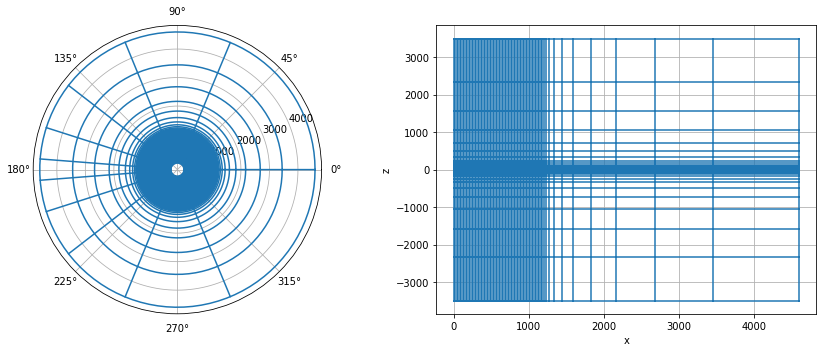

In [9]:
cylMeshGen.mesh.plotGrid()

In [10]:
cylMeshGen.mesh.nC

23100

In [11]:
src = casingSimulations.sources.HorizontalElectricDipole(
    directory=simDir, 
    modelParameters=model, 
    meshGenerator=cylMeshGen,
    physics="TDEM"
)

(0.0, 600.0)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


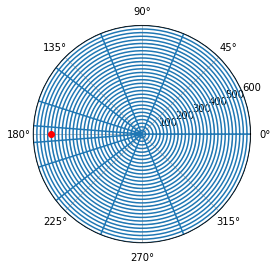

In [12]:
ax = plt.subplot(111, projection='polar')
mesh.plotGrid(ax=ax, slice='z')
ax.plot(mesh.gridFx[src.surface_wire,1], mesh.gridFx[src.surface_wire,0], 'ro')
ax.set_rlim([0., 600.])

In [13]:
physprops = casingSimulations.model.PhysicalProperties(
    modelParameters=model,
    meshGenerator=cylMeshGen
)

[(-2000.0, 0), (-2000.0, 0)]

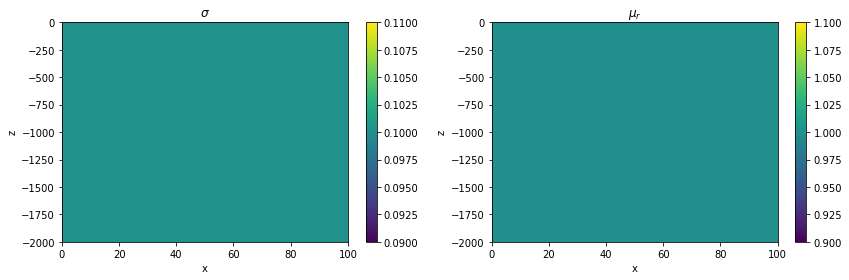

In [14]:
xlim = [0., 100.]
ylim = [-2000., 0]

ax = physprops.plot()
[a.set_xlim(xlim) for a in ax]
[a.set_ylim(ylim) for a in ax]

In [15]:
sim3D = casingSimulations.run.SimulationTDEM(
    directory=simDir,
    modelParameters=model, 
    meshGenerator=cylMeshGen, 
    src=src
)

In [16]:
fields3D = sim3D.run()

Validating parameters...
      max x: 4599.90234375, min z: -3499.90234375, max z: 3499.90234375, nC: 23100
Saved compare_TDEM_hed/simulationParameters.json
Starting SimulationTDEM
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 39.49334502220154


In [17]:
# sim3D.write_py(include2D=False, includeDC=False)

In [18]:
# sim3D._fields = sim3D.prob.fieldsPair(sim3D.meshGenerator.mesh, sim3D.survey)
# sim3D._fields[:, 'jSolution'] = np.load(simDir + "/fields.npy")

In [19]:
ana_dipole = tdem.ElectricDipoleWholeSpace(
    sigma=model.sigma_back,
    location=utils.mkvc(utils.cyl2cart(src.src_a)),
    length=cylMeshGen.csx, 
    orientation='X'
)

In [20]:
def get_numeric_analytic(time_ind, theta_ind):
    # Numeric solution
    numeric = fields3D[sim3D.survey.srcList[0], 'j', time_ind]
    numeric = casingSimulations.face3DthetaSlice(cylMeshGen.mesh, numeric, theta_ind=theta_ind)
    
    # analytic solution
    theta = cylMeshGen.mesh.vectorCCy[theta_ind]
    ana_dipole.time = sim3D.prob.times[time_ind]    
    j_x_ana = ana_dipole.current_density(utils.cyl2cart(cylMeshGen.mesh.gridFx))
    j_x_ana = utils.mkvc(np.cos(theta) * j_x_ana[:, 0] + np.sin(theta) * j_x_ana[:, 1], 2)
    
    j_y_ana = utils.mkvc(
        ana_dipole.current_density(utils.cyl2cart(cylMeshGen.mesh.gridFy))[:, 1], 2
    )
    
    j_z_ana = utils.mkvc(
        ana_dipole.current_density(utils.cyl2cart(cylMeshGen.mesh.gridFz))[:,2], 2
    )
    analytic = np.vstack([j_x_ana, j_y_ana, j_z_ana])
    
    analytic = casingSimulations.face3DthetaSlice(cylMeshGen.mesh, analytic, theta_ind=theta_ind)
    
    diff = numeric - analytic
    
    return numeric, analytic, diff

def plot_j(
    time_ind=0, 
    theta_ind=0, 
    ax = None
):
    if ax is None:
        fig, ax = plt.subplots(1,3, figsize=(15,5))
        
    mesh2D = discretize.CylMesh([cylMeshGen.mesh.hx, 1., cylMeshGen.mesh.hz], x0=cylMeshGen.mesh.x0)

    
    numeric, analytic, diff = get_numeric_analytic(time_ind, theta_ind)
    
    # plotting params
    max_field = np.abs(numeric).max() #use to set colorbar limits
    cb_range = 1e5  # dynamic range of colorbar
    cb_max = max_field
    
    titles = ['num', 'ana', 'diff']
    field_to_plot = [numeric, analytic, diff]
    for i, a in enumerate(ax):
        cb = plt.colorbar(mesh2D.plotImage(
            field_to_plot[i], 
            vType='F', view='vec', 
            range_x=[0., 1000.], range_y=[-1000., 100.],
            pcolorOpts={
                    'norm': LogNorm(), 
                    'cmap': plt.get_cmap('viridis')
                },
            streamOpts={'color': 'w'}, mirror=True, ax=a, 
            clim=[cb_max/cb_range, cb_max]
        )[0], ax=a)

        cb.set_label('j')

        # give it a title
        a.set_title(
            '{title} j, {time:10.2e} s'.format(
                title=titles[i],
                time=sim3D.prob.times[time_ind]
            )
        )
    
    plt.tight_layout()
    plt.show()
#     return ax



In [21]:
ipywidgets.interact(
    lambda time_ind, theta_ind: plot_j(time_ind, theta_ind), 
    time_ind=ipywidgets.IntSlider(min=0, max=len(sim3D.prob.timeSteps)-1, value=1), 
    theta_ind=ipywidgets.IntSlider(min=0, max=len(cylMeshGen.mesh.hy)-1, value=5) 
)

interactive(children=(IntSlider(value=1, description='time_ind', max=89), IntSlider(value=5, description='theta_ind', max=10), Output()), _dom_classes=('widget-interact',))

<function __main__.<lambda>>

In [22]:
def normalized_error(val1, val2):
    return np.linalg.norm(val1 - val2) / np.linalg.norm(0.5*(val1+val2))

In [23]:
for theta_ind in [0, 2]:
    for tind in [10, 20, 30]:
        num, ana, _ = get_numeric_analytic(tind, theta_ind)
        assert normalized_error(num, ana) < 0.1